In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
trainData = open('../../../dataFinal/preprocessed_train_text.txt', 'r').readlines()
trainLabels = open('../../../dataFinal/finalTrainLabels.labels', 'r').readlines()
testData = open('../../../dataFinal/preprocessed_test_text.txt', 'r').readlines()
testLabels = open('../../../dataFinal/finalTestLabels.labels', 'r').readlines()
validData = open('../../../dataFinal/preprocessed_trial_text.txt', 'r').readlines()
validLabels = open('../../../dataFinal/finalDevLabels.labels', 'r').readlines()

In [ ]:
for i in tqdm(range(len(trainData))):
    trainData[i] = trainData[i][:-1]
for i in tqdm(range(len(testData))):
    testData[i] = testData[i][:-1]
for i in tqdm(range(len(validData))):
    validData[i] = validData[i][:-1]

100%|██████████| 10009/10009 [00:00<00:00, 1801905.26it/s]


In [ ]:
for i in tqdm(range(len(trainLabels))):
    trainLabels[i] = int(trainLabels[i])
for i in tqdm(range(len(testLabels))):
    testLabels[i] = int(testLabels[i])
for i in tqdm(range(len(validLabels))):
    validLabels[i] = int(validLabels[i])

100%|██████████| 10008/10008 [00:00<00:00, 1411642.27it/s]


In [ ]:
trainData = trainData[1:]
testData = testData[1:]
validData = validData[1:]

In [ ]:
trainLabels = np.array(trainLabels)
testLabels = np.array(testLabels)
validLabels = np.array(validLabels)
trainLabels = trainLabels.reshape((-1, ))
testLabels = testLabels.reshape((-1, ))
validLabels = validLabels.reshape((-1, ))

In [ ]:
gloveEmbs = open('../../glove.twitter.27B.200d.txt', encoding='utf-8')

In [ ]:
embeddings = {}
for line in gloveEmbs:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
gloveEmbs.close()

In [ ]:
def embeddingOutput(X):
    """
    X: input matrix
    """
    maxLen = 10
    embDim = 200
    embOutput = np.zeros((len(X), maxLen, embDim))
    for i in range(len(X)):
        X[i] = X[i].split()
        for j in range(maxLen):
            try:
                embOutput[i][j] = embeddings[X[i][j].lower()]
            except:
                embOutput[i][j] = np.zeros((embDim, ))
    return embOutput

In [ ]:
embeddingMatrixTrain = embeddingOutput(trainData)
embeddingMatrixTest = embeddingOutput(testData)
embeddingMatrixVal = embeddingOutput(validData)

In [ ]:
embeddingMatrixTrain.shape, embeddingMatrixTest.shape, embeddingMatrixVal.shape

((69992, 10, 200), (20000, 10, 200), (10008, 10, 200))

In [ ]:
from keras.preprocessing import sequence

In [ ]:
trainData1 = trainData.copy()
testData1 = testData.copy()
validData1 = validData.copy()

In [ ]:
trainData1 = trainData1[1:]
testData1 = testData1[1:]
validData1 = validData1[1:]

In [ ]:
wordFreq = {}
for i in trainData:
    # words = i.split()
    for word in i:
        if word in wordFreq:
            wordFreq[word] += 1
        else:
            wordFreq[word] = 1

In [ ]:
len(wordFreq)

44842

In [ ]:
sortedWordFreq = dict(sorted(wordFreq.items(), reverse=True, key=lambda item: item[1]))

In [ ]:
ctr = 0
idx = 1
idxToWord = {}
wordToIdx = {}
for i in sortedWordFreq:
    # print(i, sortedWordFreq[i])
    ctr += 1
    # if sortedWordFreq[i] == 1:
        # break
    idxToWord[idx] = i
    wordToIdx[i] = idx
    idx += 1
print(ctr)

44842


In [ ]:
idxToWord[100]
wordToIdx['wait']

100

In [ ]:
for i in tqdm(range(len(trainData1))):
    words = trainData1[i]
    trainData1[i] = [wordToIdx[word] for word in words if word in wordToIdx.keys()]
for i in tqdm(range(len(testData1))):
    words = testData1[i]
    testData1[i] = [wordToIdx[word] for word in words if word in wordToIdx.keys()]
for i in tqdm(range(len(validData1))):
    words = validData1[i]
    validData1[i] = [wordToIdx[word] for word in words if word in wordToIdx.keys()]

100%|██████████| 10008/10008 [00:00<00:00, 188887.21it/s]


In [ ]:
sentLen = []
vocab = set()
for i in trainData:
    sentLen.append(len(i))
    for word in i:
        vocab.add(word)
print('min len: ', min(sentLen))
print('max len: ', max(sentLen))
print('avg len: ', np.mean(sentLen))
print('med len: ', np.median(sentLen))
print('vocab: ', len(vocab))

min len:  1
max len:  20
avg len:  6.980526345868099
med len:  7.0
vocab:  44842


In [ ]:
from keras.preprocessing import sequence

In [ ]:
X_train = sequence.pad_sequences(trainData1, maxlen=10)
X_test = sequence.pad_sequences(testData1, maxlen=10)
X_val = sequence.pad_sequences(validData1, maxlen=10)

In [ ]:
from keras.utils import np_utils

In [ ]:
trainLabels = np_utils.to_categorical(trainLabels, 20)
testLabels = np_utils.to_categorical(testLabels, 20)
validLabels = np_utils.to_categorical(validLabels, 20)

In [ ]:
trainLabels.shape, testLabels.shape, validLabels.shape

((69992, 20), (20000, 20), (10008, 20))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, RNN, Dense, Dropout, Embedding, RNN, Bidirectional, Add, merge, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(10, 200))) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPointLoss = ModelCheckpoint('lstmBestLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
checkPointAcc = ModelCheckpoint('lsmtBestAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPointLoss, checkPointAcc, earlyStopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 69,140
Trainable params: 69,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
545/547 [============================>.] - ETA: 0s - loss: 2.5629 - accuracy: 0.2664
Epoch 00001: val_loss improved from inf to 2.41182, saving model to lstmBestLoss.h5

Epoch 00001: val_accuracy improved from -inf to 0.29986, saving model to lsmtBestLoss.h5
547/547 [==============================] - 16s

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lstmBestLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lstmBestAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 3s 5ms/step - loss: 2.3238 - accuracy: 0.3178


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-8ba6d2b5b697>", line 4, in <module>
    model.load_weights('lstmBestAcc.h5')
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/h5py/_hl/files.py", line 427, in __init__
    swmr=swmr)
  File "/usr/local/lib/python3.7/dist-packages/h5py/_hl/files.py", line 190, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 96, in h5py.h5f.open
OSError: Unable to open file (unable to open file: name = 'lstmBestAcc.h5', errno = 2, error message = 'No such file o

OSError: ignored

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(10, 200))) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPointLoss = ModelCheckpoint('lstmBestLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
checkPointAcc = ModelCheckpoint('lsmtBestAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPointLoss, checkPointAcc, earlyStopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
Total params: 126,470
Trainable params: 126,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
547/547 [==============================

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lstmBestLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lsmtBestAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 3s 5ms/step - loss: 2.3325 - accuracy: 0.3181


[2.332508087158203, 0.3181000053882599]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('seaborn')

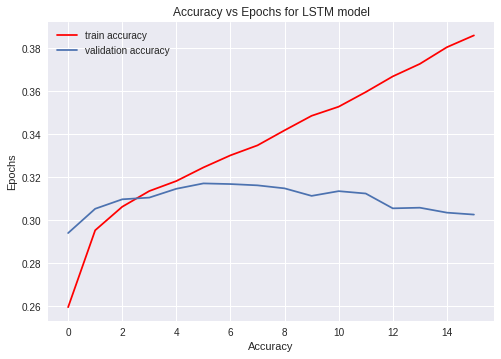

In [ ]:
plt.plot(hist.history['accuracy'], label='train accuracy', c='red')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.title('Accuracy vs Epochs for LSTM model')
plt.show()

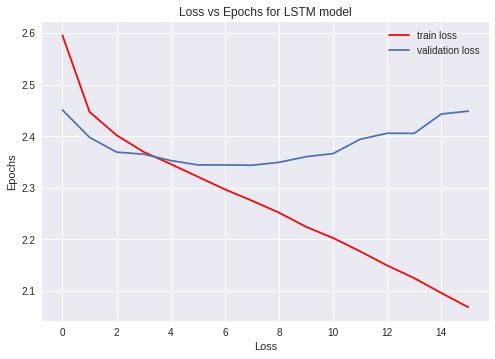

In [ ]:
plt.plot(hist.history['loss'], label='train loss', c='red')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.title('Loss vs Epochs for LSTM model')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds = model.predict(embeddingMatrixTest)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(testLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.29      0.80      0.43      4312
           1       0.26      0.11      0.16      2022
           2       0.33      0.51      0.40      1955
           3       0.00      0.00      0.00      1099
           4       0.39      0.44      0.41      1246
           5       0.00      0.00      0.00       786
           6       0.15      0.01      0.02       809
           7       0.31      0.16      0.21       928
           8       0.00      0.00      0.00       669
           9       0.00      0.00      0.00       569
          10       0.00      0.00      0.00       595
          11       0.46      0.40      0.43       696
          12       0.30      0.47      0.37       546
          13       0.00      0.00      0.00       492
          14       0.00      0.00      0.00       536
          15       0.27      0.04      0.07       498
          16       0.00      0.00      0.00       492
          17       0.61    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
preds = model.predict(embeddingMatrixVal)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(validLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.29      0.81      0.43      2156
           1       0.27      0.10      0.15      1011
           2       0.33      0.49      0.40       978
           3       0.00      0.00      0.00       549
           4       0.37      0.43      0.40       624
           5       0.00      0.00      0.00       393
           6       0.15      0.01      0.02       405
           7       0.33      0.17      0.23       465
           8       0.00      0.00      0.00       335
           9       0.00      0.00      0.00       285
          10       0.00      0.00      0.00       298
          11       0.46      0.40      0.43       348
          12       0.30      0.44      0.36       273
          13       0.00      0.00      0.00       246
          14       0.00      0.00      0.00       269
          15       0.14      0.02      0.04       250
          16       0.00      0.00      0.00       246
          17       0.61    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
preds = model.predict(embeddingMatrixTrain)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(trainLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.30      0.82      0.44     15090
           1       0.35      0.14      0.20      7076
           2       0.37      0.56      0.44      6842
           3       0.00      0.00      0.00      3842
           4       0.44      0.50      0.47      4363
           5       0.00      0.00      0.00      2751
           6       0.24      0.02      0.03      2831
           7       0.40      0.21      0.27      3250
           8       0.00      0.00      0.00      2341
           9       0.00      0.00      0.00      1992
          10       0.00      0.00      0.00      2083
          11       0.55      0.49      0.52      2433
          12       0.35      0.51      0.41      1908
          13       0.00      0.00      0.00      1722
          14       1.00      0.00      0.00      1878
          15       0.36      0.07      0.11      1745
          16       0.00      0.00      0.00      1721
          17       0.61    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPointLoss = ModelCheckpoint('lstmBestLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
checkPointAcc = ModelCheckpoint('lsmtBestAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPointLoss, checkPointAcc, earlyStopping])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 100)           120400    
                                                                 
 dropout_6 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_7 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)               

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lstmBestLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lsmtBestAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 4s 6ms/step - loss: 2.3314 - accuracy: 0.3178


[2.3313639163970947, 0.3178499937057495]

In [ ]:
model = Sequential()
model.add(Embedding(44843, 200, trainable=True))
model.add(LSTM(100)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPointLoss = ModelCheckpoint('lstmBestLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
checkPointAcc = ModelCheckpoint('lsmtBestAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPointLoss, checkPointAcc, earlyStopping])


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPointLoss = ModelCheckpoint('lstmBestLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
checkPointAcc = ModelCheckpoint('lsmtBestAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPointLoss, checkPointAcc, earlyStopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 100)           120400    
                                                                 
 dropout_3 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_4 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_5 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 100)          

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lstmBestLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('lsmtBestAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 15s 24ms/step - loss: 2.3875 - accuracy: 0.3130


[2.387470006942749, 0.31299999356269836]

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModel.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 3s 5ms/step - loss: 2.3243 - accuracy: 0.3184


[2.3243110179901123, 0.31839999556541443]

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(64)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPoint = ModelCheckpoint('bestModel.h5', monitor='val_loss', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPoint, earlyStopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            67840     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 102,164
Trainable params: 102,164
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
546/547 [============================

In [ ]:
model = Sequential()
model.add(Embedding(44843, 200, trainable=True))
model.add(LSTM(100)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPointLoss = ModelCheckpoint('lstmBestLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
checkPointAcc = ModelCheckpoint('lsmtBestAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=True)
hist = model.fit(X_train, trainLabels, epochs=50, batch_size=128,
                 validation_data=(X_val, validLabels), shuffle=True, callbacks=[checkPointLoss, checkPointAcc, earlyStopping])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 200)         8968600   
                                                                 
 lstm_12 (LSTM)              (None, 100)               120400    
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                1020      
                                                                 
Total params: 9,095,070
Trainable params: 9,095,070
No

In [ ]:
model.evaluate(X_test, testLabels)
model.load_weights('lstmBestLoss.h5')
model.evaluate(X_test, testLabels)
model.load_weights('lsmtBestAcc.h5')
model.evaluate(X_test, testLabels)

625/625 [==============================] - 4s 6ms/step - loss: 2.4402 - accuracy: 0.2986


[2.4401957988739014, 0.2985999882221222]

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModel.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 4s 6ms/step - loss: 2.3237 - accuracy: 0.3204


[2.3236546516418457, 0.3203999996185303]

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(128)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPoint = ModelCheckpoint('bestModel.h5', monitor='val_loss', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPoint, earlyStopping])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 10, 128)           168448    
                                                                 
 dropout_6 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                2580      
                                                                 
Total params: 302,612
Trainable params: 302,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
547/547 [============================

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModel.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 8s 12ms/step - loss: 2.3173 - accuracy: 0.3194


[2.317291736602783, 0.319350004196167]

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(32)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
checkPoint = ModelCheckpoint('bestModel.h5', monitor='val_loss', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPoint, earlyStopping])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 128)           168448    
                                                                 
 dropout_15 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_21 (LSTM)              (None, 10, 64)            49408     
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 20)              

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-21731bf311b8>", line 14, in <module>
    validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPoint, earlyStopping])
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/pyth

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModel.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 7s 11ms/step - loss: 2.3405 - accuracy: 0.3189


[2.3405096530914307, 0.31894999742507935]

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(32)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
lossCheck = ModelCheckpoint('bestModelLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
accCheck = ModelCheckpoint('bestModelAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[lossCheck, accCheck, earlyStopping])


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 10, 128)           168448    
                                                                 
 dropout_18 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_24 (LSTM)              (None, 10, 64)            49408     
                                                                 
 dropout_19 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 20)              

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModelLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModelAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 7s 12ms/step - loss: 2.3585 - accuracy: 0.3178


[2.3585457801818848, 0.3177500069141388]

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(10, 200), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(32)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
lossCheck = ModelCheckpoint('bestModelLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
accCheck = ModelCheckpoint('bestModelAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[lossCheck, accCheck, earlyStopping])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 10, 128)           168448    
                                                                 
 dropout_21 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_27 (LSTM)              (None, 10, 64)            49408     
                                                                 
 dropout_22 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_28 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 100)             

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModelLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bestModelAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 7s 12ms/step - loss: 2.3533 - accuracy: 0.3153


[2.3532633781433105, 0.3152500092983246]

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 3s 5ms/step - loss: 2.4530 - accuracy: 0.2957


[2.4530069828033447, 0.29565000534057617]

In [ ]:
model.load_weights('bestModel.h5')

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 3s 4ms/step - loss: 2.3620 - accuracy: 0.3084


[2.3619701862335205, 0.3084000051021576]

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(10, 50), return_sequences=True)) #hidden state has 64 dims
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            29440     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 63,764
Trainable params: 63,764
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkPoint = ModelCheckpoint('bestModel.h5', monitor='val_loss', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[checkPoint])


Epoch 1/50
546/547 [============================>.] - ETA: 0s - loss: 2.6050 - accuracy: 0.2535
Epoch 00001: val_loss improved from inf to 2.47624, saving model to bestModel.h5
547/547 [==============================] - 28s 41ms/step - loss: 2.6048 - accuracy: 0.2536 - val_loss: 2.4762 - val_accuracy: 0.2785
Epoch 2/50
547/547 [==============================] - ETA: 0s - loss: 2.4917 - accuracy: 0.2804
Epoch 00002: val_loss improved from 2.47624 to 2.44055, saving model to bestModel.h5
547/547 [==============================] - 21s 38ms/step - loss: 2.4917 - accuracy: 0.2804 - val_loss: 2.4405 - val_accuracy: 0.2867
Epoch 3/50
547/547 [==============================] - ETA: 0s - loss: 2.4573 - accuracy: 0.2891
Epoch 00003: val_loss improved from 2.44055 to 2.41873, saving model to bestModel.h5
547/547 [==============================] - 20s 37ms/step - loss: 2.4573 - accuracy: 0.2891 - val_loss: 2.4187 - val_accuracy: 0.2914
Epoch 4/50
547/547 [==============================] - ETA: 0s 

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 6s 7ms/step - loss: 2.4827 - accuracy: 0.2964


[2.482708215713501, 0.2964000105857849]

In [ ]:
model.load_weights('bestModel.h5')

In [ ]:
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 5s 7ms/step - loss: 2.3595 - accuracy: 0.3091


[2.359462022781372, 0.3091000020503998]